## ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

#### Формулировка задачи

Тип: обучение с учителем  
Вид: линейная регрессия

Задача: модель должна аппроксимировать целевую переменную по данным признаком методом восстановления линейной регресси

#### Импорт библиотек и определение служебных функций

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date
import datetime

from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Загрузка и анализ датасета

In [73]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

In [74]:
ytr.shape

(10000, 1)

In [75]:
Xtr.shape

(10000, 4)

In [76]:
N = Xtr.shape[0]
N

10000

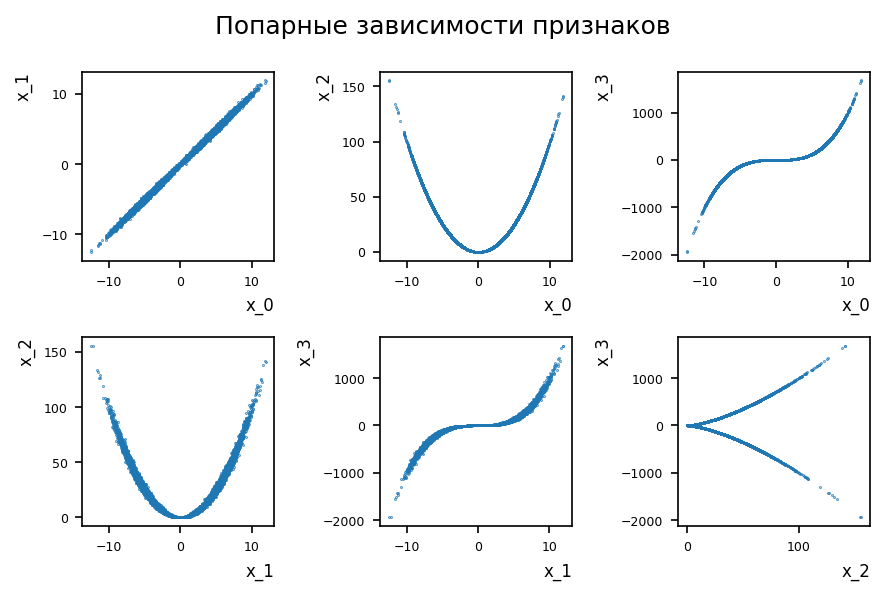

In [77]:
f = plt.figure(figsize=(6,4), dpi=150)
pic=1
for p in range(0,4):
    for k in range(0,4):
        if(k!=p and k>p):
            plt.subplot(2,3,pic)
            plt.scatter(Xtr[:,p], Xtr[:,k],s=0.1)
            plt.xlabel(f'x_{p}', fontsize=8, loc='right')
            plt.ylabel(f'x_{k}', fontsize=8, loc='top')
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            pic+=1
plt.suptitle("Попарные зависимости признаков")
plt.tight_layout()

In [78]:
np.corrcoef(Xtr, rowvar=False)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

Видно, что признаки 0 и 1 сильно скореллированы, и нет смысла рассматривать их вместе. Поэтому составим из 0 и 1 признака линейную комбинацию и сделаем её новым признаком. Теперь размерномть признакового пространства - 3:

In [79]:
X = Xtr[:, 1:]
for i in range(0, 10000):
    X[i, 0] = 0.5*(Xtr[i, 0]+Xtr[i, 1])

Xtr = X

print(np.shape(Xtr), np.shape(ytr))

(10000, 3) (10000, 1)


In [80]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(x=Xtr[:,0],
                                   y=Xtr[:,1],
                                   z=Xtr[:,2],
                                   mode='markers',
                                   marker=dict(size=1))
                     ])
fig.update_layout(autosize=False,
                  width=500,
                  height=500,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='x2'),
                 title_text="Визуализация признаков", title_x=0.5)
fig.show()

In [81]:
fig = go.Figure(data=[go.Scatter3d(
    x=Xtr[:,0], y=Xtr[:,1], z=Xtr[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=ytr[:,0], 
        colorscale='Rainbow',
        opacity=1,
        colorbar=dict(thickness=20)
    )
)])

# tight layout
fig.update_layout(autosize=False,
                  width=600,
                  height=600,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='x2'),
                 title_text='Визуализация целевой переменной на новых признаках', title_x=0.5)
fig.show()

#### Реализация вычисления функции потерь и вычисления градиента функции потерь
Код далее написан в соответствии со схемой на рисунке. В качестве начального приближения параметров модели $\Theta$ берутся случайные значения

In [82]:
class Differentiable:
    def __init__(self):
        self.cache = None
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [83]:
class linear(Differentiable):
    def __init__(self):
        super(linear, self).__init__()
        self.theta = None
        self.cache = None
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            self.theta = np.random.randn(X.shape[1]+1, 1)
            # self.theta = np.zeros(X.shape[1]+1, 1)
            # self.theta = [ -1, 1.5, 0.5, 0.1]
        
        z = (X_matrix).dot(self.theta)
        self.cache = X_matrix
        
        return z
    
    def backward(self, usg):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        
        assert self.cache is not None, "please perform forward pass first"
        
        partial_grad = (usg.T).dot(self.cache)
        self.cache = None

        return partial_grad

In [84]:
class Identity(Differentiable):
    def __init__(self):
        super(Identity, self).__init__()
    
    def __call__(self, z):
        # этот метод предназначен для вычисления значения функции активации
        return self.forward(z)
    
    def forward(self, z): 
        self.cache = 1
        return z
    
    def backward(self, usg):
        return usg*self.cache

In [85]:
class Residual(Differentiable):
    def __init__(self):
        super(Residual, self).__init__()
    
    def __call__(self, mu, y):
        return self.forward(mu, y)
    
    def forward(self, mu, y):
        d = y - mu
        self.cache = -1
        
        return d
    
    def backward(self, usg):
        partial_grad = usg*self.cache
        
        return partial_grad

In [86]:
class MSE(Differentiable):
    def __init__(self):
        super(MSE, self).__init__()
    
    def __call__(self, d):
        return self.forward(d)
    
    def forward(self, d):
        mse_value = np.sum(d**2)
        # self.cache = 2*d/d.shape[0]
        self.cache = 2*d
        
        return mse_value
    
    
    def backward(self, usg):
        partial_grad = usg*self.cache
        return partial_grad
    

In [87]:
class NN(Differentiable):
    def __init__(self):
        super(NN, self).__init__()
        self.l1 = linear()
        self.act = Identity()
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        # Этот метод будет вычислять нейросеть на данных X
        mu = self.act.forward(self.l1.forward(X))
        return mu
    
    def backward(self, usg):
        grad = self.l1.backward(self.act.backward(usg))
        return grad

In [88]:
class Loss(Differentiable):
    def __init__(self):
        super(Loss, self).__init__()
        self.dev = Residual()
        self.mse = MSE()
    
    def __call__(self, mu, y):
        return self.forward(mu, y)
    
    def forward(self, mu, y):
        l = self.mse.forward(self.dev.forward(mu, y))
        return l
    
    def backward(self, usg):
        grad = self.dev.backward(self.mse.backward(usg))
        return grad

In [89]:
def clip_by_norm(grad, max_norm = 1.0):
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_norm:
        grad = max_norm * grad / grad_norm
    return grad

In [90]:
network = NN()
loss_fn = Loss()

### Далее идет процедура обучения созданной нейросети

Поделим датасет на тренировочную и тестовую выборки размером 9000 и 1000 элементов соответственно

In [91]:
import random
Nb = 9000
indexes = np.arange(ytr.shape[0])
random.shuffle(indexes)

X_train = Xtr[indexes[:Nb]]
y_train = ytr[indexes[:Nb]]
X_test = Xtr[indexes[Nb:]]
y_test = ytr[indexes[Nb:]]


In [92]:
learning_rate = 1e-4
epochs = 100000

loss_history = []
pbar = tqdm(total=epochs)

for epoch in range(epochs):

    mu = network(X_train)
    loss_value = loss_fn(mu, y_train)/N
    grad = network.backward(loss_fn.backward(1))
    grad = clip_by_norm(grad, 1.0)
    grad = np.reshape(np.array(grad),(4, 1))
    
    # update network parameters
    network.l1.theta -=  learning_rate*grad
    loss_history.append(loss_value)
    pbar.update(1)
    pbar.set_postfix({'loss': loss_value})
pbar.close()

100%|██████████| 100000/100000 [02:05<00:00, 797.47it/s, loss=0.537]


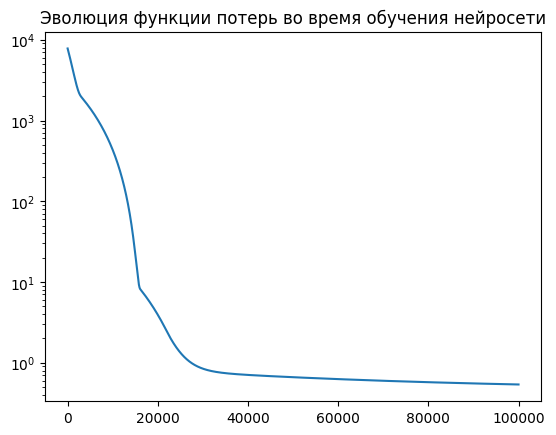

In [93]:
# отобразите эволюцию функции потерь по мере обучения сети
plt.plot(loss_history[0:100000])
plt.yscale('log')
plt.title("Эволюция функции потерь во время обучения нейросети")
plt.show()

In [94]:
loss_history[90000]

np.float64(0.5535859762083984)

In [95]:
fin_theta = network.l1.theta
print(fin_theta)

[[-0.48309311]
 [-1.43987699]
 [ 0.52279442]
 [ 0.08104654]]


#### Использование обученной нейросети
Для меры качества воспоьзуемся функцией RMSE

In [96]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.squeeze(np.asarray(y_true)) - np.squeeze(np.asarray(y_pred))))/y_pred.shape[0])

In [97]:
# примените нейросеть к данным тестовой выборки
mu = network(X_test)

In [98]:
print(mu.shape)
quality = RMSE(y_test, mu)
print(quality)

(1000, 1)
0.7445725435415257


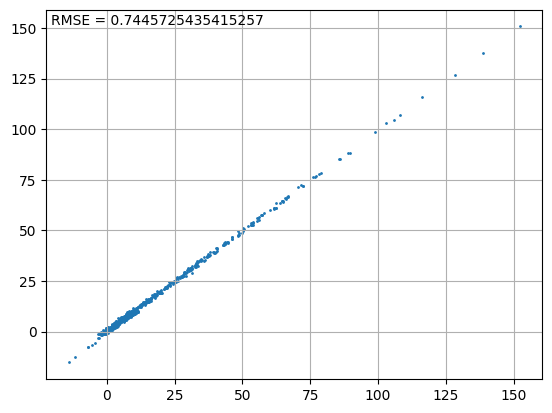

In [99]:
# отобразите диаграмму y(y_true) для оценки соответствия полученного решения известному
f, ax = plt.subplots()
plt.scatter(y_test, mu, s=1)
plt.text(.01, .99, f'RMSE = {quality}', ha='left', va='top', transform=ax.transAxes)
plt.grid()
plt.show()


In [100]:
mu = network(X_train)
print(mu.shape)
quality = RMSE(y_train, mu)
print(quality)

(9000, 1)
0.7726247746134716


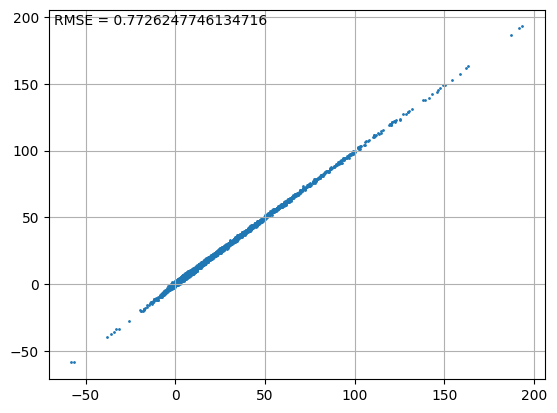

In [101]:
# отобразите диаграмму y(y_true) для оценки соответствия полученного решения известному
f, ax = plt.subplots()
plt.scatter(y_train, mu, s=1)
plt.text(.01, .99, f'RMSE = {quality}', ha='left', va='top', transform=ax.transAxes)
plt.grid()
plt.show()


### Выводы

1. Модель достаточно c хорошей точностью описывает предложенные данные;
2. Изначально датасет содержал излишнее число признаков. Перед обучением модели мы объеденили два скоррелированных признака в один через линейную функцию;
3. Во время обучения модели методом градиентного спуска функция потерь вышла на константный минимум, что говорит о достаточной обученности модели. Полученные в результате параметры модели оказалось близко к значениям, полученным в одном из прошлогодних домашних заданий на том же наборе данных;
4. Оценки качества модели на тренировочной выборке и на тестовой с хорошей точностью совпадают, что говорит о хорошей обобщающей способности модели. Значение качества модели зависит от удачности или неудачности начального приближения параметров модели, которое в этом решении выбирается случайно.